# PSPNet + PoseNet + ACGPN

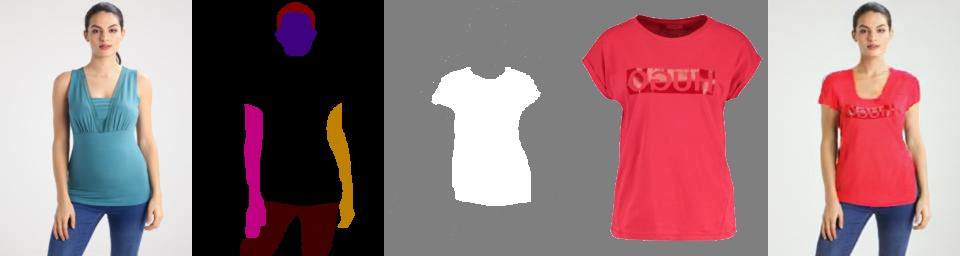

#### real_image (original) -----> pose_map -----> cloth_mask -----> color (dress) -----> fake_image (generated)

#### License: The use of this software is RESTRICTED to non-commercial research and educational purposes.

## Dataset: VITON dataset 
    This dataset contains 16,253 image pairs, further splitting into a training set of 14,221 paris and a testing set of 2,032 pairs.

## Copy Dataset

In [63]:
!mkdir Dataset

#### copy VITON dataset (color, edge, mask, colormask)

In [64]:
# copy VITON dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_color Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_edge Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_mask Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_colormask Dataset

#### copy TestData (image, pose, label)

In [65]:
# copy TestData
!cp -r /kaggle/input/tryon-testdata/Dataset/test_img Dataset
!cp -r /kaggle/input/tryon-testdata/Dataset/test_pose Dataset
!cp -r /kaggle/input/tryon-testdata/Dataset/test_label Dataset
!rm Dataset/test_pose/*
!rm Dataset/test_label/*

# Semantic Segmentation: [PSPNet](https://arxiv.org/abs/1505.07427)-MobileNet-v2


![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fhszhao.github.io%2Fprojects%2Fpspnet%2Ffigures%2Fpspnet.png&f=1&nofb=1)

## Repro [Github](https://github.com/IanTaehoonYoo/semantic-segmentation-pytorch) (semantic-segmentation-pytorch)

In [66]:
!git clone https://github.com/rkuo2000/semantic-segmentation-pytorch # predict.py add output a _gray.png
%cd semantic-segmentation-pytorch

In [67]:
from torchvision import transforms

from segmentation.data_loader.segmentation_dataset import SegmentationDataset
from segmentation.data_loader.transform import Rescale, ToTensor
from segmentation.trainer import Trainer
from segmentation.predict import *
from segmentation.models import all_models
from util.logger import Logger

In [68]:
model_name = "pspnet_mobilenet_v2"
device = 'cuda'
batch_size = 4
n_classes = 34 
check_point_stride = 1 # store checkpoints every 1 epoch   
image_axis_minimum_size = 200

num_epochs = 0    # 1 for 1st training
                  # n for retraining
                  # 0 for detect-only
pretrained = False# True  for num_epochs=1 without logger.load_model below
                  # False for num_epochs=n with    logger.load_model below
                  # False for detect-only  with    logger.load_model below
fixed_feature = False

logger = Logger(model_name=model_name, data_name='example')

In [69]:
! nvidia-smi

In [70]:
### Model
model = all_models.model_from_name[model_name](n_classes, batch_size, 
                                               pretrained=pretrained, 
                                               fixed_feature=fixed_feature)
model.to(device)

## Load checkpoint 

In [71]:
# copy checkpoint
!mkdir -p runs/models/pspnet_mobilenet_v2/example
!cp /kaggle/input/pspnet-viton-checkpoints/epoch_1 runs/models/pspnet_mobilenet_v2/example

# Load checkpoint
logger.load_model(model,'epoch_1')

## Detect label (semantic segmentation)

In [72]:
test_img_file   = '../Dataset/test_img/000000_0.jpg'
test_label_file = '../Dataset/test_label/000000_0.png'

In [73]:
### Writing gray label
predict(model, test_img_file, test_label_file )

## Show image & its label (segmentation)

In [74]:
from IPython.display import Image

In [75]:
# show test image
Image(test_img_file)

In [76]:
# show test color label
Image(test_label_file)

In [77]:
# show test gray label
Image(test_label_file.replace('.png','_gray.png'))

In [78]:
# copy gray label to overwrite color label as test_label .png
!mv ../Dataset/test_label/000000_0_gray.png ../Dataset/test_label/000000_0.png

In [79]:
%cd ..

# Pose Detection: [PoseNet](https://arxiv.org/abs/1505.07427)

![](https://github.com/tensorflow/tfjs-models/raw/master/posenet/demos/camera.gif)

In [80]:
!pip install tfjs-graph-converter

## Repro [Github](https://github.com/rwightman/posenet-pytorch) (PoseNet-PyTorch)

In [81]:
!git clone https://github.com/rwightman/posenet-pytorch  # fix bugs
%cd posenet-pytorch

In [82]:
file = '../Dataset/test_img/000000_0.jpg'

In [83]:
import torch
from posenet.constants import *
from posenet.decode_multi import decode_multiple_poses
from posenet.models.model_factory import load_model
from posenet.utils import *

net = load_model(101)
net = net.cuda()
output_stride = net.output_stride
scale_factor = 1.0

input_image, draw_image, output_scale = posenet.read_imgfile(file, scale_factor=scale_factor, output_stride=output_stride)

## Detect Pose keypoints

In [84]:
import torch
with torch.no_grad():
    input_image = torch.Tensor(input_image).cuda()

    heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = net(input_image)

    pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
        heatmaps_result.squeeze(0),
        offsets_result.squeeze(0),
        displacement_fwd_result.squeeze(0),
        displacement_bwd_result.squeeze(0),
        output_stride=output_stride,
        max_pose_detections=10,
        min_pose_score=0.25)

### find keypoint coordinates in poses

In [85]:
import matplotlib.pyplot as plt
# read image
image = plt.imread(file)

poses = []
# find face keypoints & detect face mask
for pi in range(len(pose_scores)):
    if pose_scores[pi] != 0.:
        print('Pose #%d, score = %f' % (pi, pose_scores[pi]))       
        keypoints = keypoint_coords.astype(np.int32) # convert float to integer
        print(keypoints[pi])
        poses.append(keypoints[pi])
print(len(poses))

### show PoseNet keypoints

In [86]:
img = plt.imread(file)
i=0
pose = poses[0]
plt.imshow(img)    
for y,x in pose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1   
plt.show()

### PoseNet output
![](https://debuggercafe.com/wp-content/uploads/2020/10/keypoint_exmp.jpg)

### OpenPose COCO format
![](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/.github/media/keypoints_pose_18.png?raw=true)

## Convert Keypoints (from PoseNet to OpenPose)

In [87]:
# map rccpose-to-openpose mapping
indices = [0, (5,6), 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]

In [88]:
# convert rcnnpose to openpose
i=0
openpose = []
for ix in indices:
    if ix==(5,6):
        openpose.append([int((pose[5][1]+pose[6][1])/2), int((pose[5][0]+pose[6][0])/2), 1])   
    else:
        openpose.append([int(pose[ix][1]),int(pose[ix][0]),1])        
    i+=1
    
print(openpose)

In [89]:
plt.imshow(img)
i=0
for x,y,z in openpose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()

### save keypoints.json

In [90]:
import json
coords = []
for x,y,z in openpose:
    coords.append(float(x))
    coords.append(float(y))
    coords.append(float(z))

data = {"version": 1.0}
pose_dic = {}
pose_dic['pose_keypoints'] = coords
tmp = []
tmp.append(pose_dic)
data["people"]=tmp
print(data)

pose_name = '../Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name,'w') as f:
     json.dump(data, f)  

## Verify _keypoints.json

In [91]:
%cd ..

### read .json

In [92]:
# read pose
import numpy as np
import json
#pose_name = '/kaggle/input/tryon-testdata/Dataset/test_pose/000000_0_keypoints.json'
pose_name = 'Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name, 'r') as f:
     pose_label = json.load(f)
     pose_data = pose_label['people'][0]['pose_keypoints']
     pose_data = np.array(pose_data)
     pose_data = pose_data.reshape((-1,3))
print(pose_data)
print(len(pose_data))

### draw keypoints 

In [93]:
# show pose keypoints on the test image
img = plt.imread('/kaggle/input/tryon-testdata/Dataset/test_img/000000_0.jpg')
plt.imshow(img)
i=0
for x,y,z in pose_data: 
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()
print(i)

# Try On: [Towards Photo-Realistic Virtual Try-On by Adaptively Generating, CVPR'20](https://arxiv.org/abs/2003.05863)

![](https://github.com/switchablenorms/DeepFashion_Try_On/raw/master/images/tryon.png)

## Repro [Github](https://github.com/switchablenorms/DeepFashion_Try_On) (DeepFashion Try On)

In [94]:
!git clone https://github.com/rkuo2000/DeepFashion_Try_On
%cd DeepFashion_Try_On

### Download pre-trained model (checkpoint)

In [95]:
%cd ACGPN_inference

In [96]:
# copy the pre-trained model (checkpoint)
!cp -rf /kaggle/input/acgpn-checkpoints/label2city checkpoints

## Test TryOn model 

In [97]:
!python test.py --dataroot ../../Dataset --color_name 000118_1.jpg

#### output : sample/000000_0.jpg

### Display TryOn result

In [98]:
from IPython.display import Image
Image('./sample/000000_0.jpg')